In [45]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ggplot # testing out some ggplot goodness in python
%matplotlib inline

2/14/17

In this notebook I test census data tables imported into my ec2 development db for the Hack OR Emergency Response team project.

In [2]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

In [3]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("database"), user=os.environ.get("user"), 
                            password = os.environ.get("password"), 
                            host=os.environ.get("host"), port=os.environ.get("port"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [4]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()


In [5]:
# get all rows from census block to fma lookup table 
QUERY1='''SELECT *
FROM fmac_proportion;
'''

In [6]:
df1 = pquery(QUERY1)

Opened database successfully
SQL QUERY = SELECT *
FROM fmac_proportion;



In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 4 columns):
c_block        770 non-null object
fma            770 non-null object
overlap_cbg    770 non-null float64
overlap_fma    770 non-null float64
dtypes: float64(2), object(2)
memory usage: 24.1+ KB


In [8]:
df1.head(25)

,c_block,fma,overlap_cbg,overlap_fma
0,410050201001,10,0.002468,7.874073e-04
1,410050203032,10,0.000015,7.926580e-07
2,410050203041,18,0.000056,4.442453e-06
3,410050208001,10,0.001001,2.550445e-04
4,410050208001,20,0.055454,1.285901e-02
5,410050209001,20,0.239613,8.783360e-03
6,410050210001,25,0.003061,1.808271e-04
7,410050210002,20,0.006363,6.558618e-04
8,410050210002,25,0.015021,1.445884e-03
9,410050212001,20,0.042128,4.428812e-03


Each row in this lookup table is an intersection of census block group (c_block) to Fire Management Area (fma). 

* overlap_cbg is the proprtion calculated by intersection area / total census block area

* overlap_fma is the proportion calculated by intersection area / total fma area



**Now I test some queries converting data by census block group to fma**

In [9]:
# try joining census total population by census block group to fma
QUERY2='''SELECT f.fma,
  round(sum(c.estimate_total*f.overlap_cbg)) AS fma_population_total
FROM fmac_proportion f INNER JOIN census_total_population c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY fma_population_total DESC
'''

In [10]:
df2 = pquery(QUERY2)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_total*f.overlap_cbg)) AS fma_population_total
FROM fmac_proportion f INNER JOIN census_total_population c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY fma_population_total DESC



In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
fma                     31 non-null object
fma_population_total    31 non-null float64
dtypes: float64(1), object(1)
memory usage: 576.0+ bytes


In [12]:
df2

,fma,fma_population_total
0,07,42544.0
1,25,41133.0
2,14,37634.0
3,09,34321.0
4,11,34236.0
5,31,31487.0
6,19,30588.0
7,28,28355.0
8,18,27347.0
9,29,24628.0


In [13]:
# try joining census housing_tenure by census block group to fma
QUERY3='''SELECT f.fma,
  round(sum(c.estimate_total_households*f.overlap_cbg)) AS total_households,
  round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS total_owner_occupied,
  round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS total_renter_occupied
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY total_households DESC
'''

In [14]:
df3 = pquery(QUERY3)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_total_households*f.overlap_cbg)) AS total_households,
  round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS total_owner_occupied,
  round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS total_renter_occupied
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY total_households DESC



In [15]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
fma                      31 non-null object
total_households         31 non-null float64
total_owner_occupied     31 non-null float64
total_renter_occupied    31 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.0+ KB


In [16]:
df3

,fma,total_households,total_owner_occupied,total_renter_occupied
0,25,17263.0,9648.0,7615.0
1,09,15456.0,8071.0,7385.0
2,07,14879.0,6141.0,8738.0
3,14,14326.0,9551.0,4775.0
4,03,14052.0,3640.0,10412.0
5,19,12574.0,6989.0,5585.0
6,11,12245.0,6399.0,5847.0
7,28,11831.0,7678.0,4153.0
8,18,11570.0,7581.0,3989.0
9,13,11457.0,4717.0,6741.0


In [17]:
# try joining census estimate_median_household_income by census block group to fma
# note this is not a statistically valid query since we can't simply apply a weighted average to medians
# but it's at least one approach to approximate a median for fmas

QUERY4='''SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income
FROM fmac_proportion f INNER JOIN census_median_household_income c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY median_household_income DESC
'''

In [18]:
df4 = pquery(QUERY4)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income
FROM fmac_proportion f INNER JOIN census_median_household_income c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY median_household_income DESC



In [19]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
fma                        31 non-null object
median_household_income    31 non-null float64
dtypes: float64(1), object(1)
memory usage: 576.0+ bytes


In [20]:
df4

,fma,median_household_income
0,27,137883.0
1,16,130537.0
2,15,117597.0
3,10,108234.0
4,05,90861.0
5,03,90696.0
6,06,84673.0
7,18,81527.0
8,22,72752.0
9,09,71971.0


In [25]:
# try joining census_household_income by census block group to fma to look at income distribution

QUERY5='''SELECT f.fma,
  round(sum(c.total_less_than_10000*f.overlap_fma)) AS less_than_10000,
  round(sum(c.total_10000_to_14999*f.overlap_fma)) AS fr_10000_to_14999,
  round(sum(c.total_15000_to_19999*f.overlap_fma)) AS fr_15000_to_19999,
  round(sum(c.total_20000_to_24999*f.overlap_fma)) AS fr_20000_to_24999,
  round(sum(c.total_25000_to_29999*f.overlap_fma)) AS fr_25000_to_29999,
  round(sum(c.total_30000_to_34999*f.overlap_fma)) AS fr_30000_to_34999,
  round(sum(c.total_35000_to_39999*f.overlap_fma)) AS fr_35000_to_39999,
  round(sum(c.total_40000_to_44999*f.overlap_fma)) AS fr_40000_to_44999,
  round(sum(c.total_45000_to_49999*f.overlap_fma)) AS fr_45000_to_49999,
  round(sum(c.total_50000_to_59999*f.overlap_fma)) AS fr_50000_to_59999,
  round(sum(c.total_60000_to_74999*f.overlap_fma)) AS fr_60000_to_74999,
  round(sum(c.total_75000_to_99999*f.overlap_fma)) AS fr_75000_to_99999,
  round(sum(c.total_100000_to_124999*f.overlap_fma)) AS fr_100000_to_124999,
  round(sum(c.total_125000_to_149999*f.overlap_fma)) AS fr_125000_to_149999,
  round(sum(c.total_150000_to_199999*f.overlap_fma)) AS fr_150000_to_199999,
  round(sum(c.total_200000_or_more*f.overlap_fma)) AS fr_200000_or_more
FROM fmac_proportion f INNER JOIN census_household_income c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY f.fma
'''

In [26]:
df5 = pquery(QUERY5)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total_less_than_10000*f.overlap_fma)) AS less_than_10000,
  round(sum(c.total_10000_to_14999*f.overlap_fma)) AS fr_10000_to_14999,
  round(sum(c.total_15000_to_19999*f.overlap_fma)) AS fr_15000_to_19999,
  round(sum(c.total_20000_to_24999*f.overlap_fma)) AS fr_20000_to_24999,
  round(sum(c.total_25000_to_29999*f.overlap_fma)) AS fr_25000_to_29999,
  round(sum(c.total_30000_to_34999*f.overlap_fma)) AS fr_30000_to_34999,
  round(sum(c.total_35000_to_39999*f.overlap_fma)) AS fr_35000_to_39999,
  round(sum(c.total_40000_to_44999*f.overlap_fma)) AS fr_40000_to_44999,
  round(sum(c.total_45000_to_49999*f.overlap_fma)) AS fr_45000_to_49999,
  round(sum(c.total_50000_to_59999*f.overlap_fma)) AS fr_50000_to_59999,
  round(sum(c.total_60000_to_74999*f.overlap_fma)) AS fr_60000_to_74999,
  round(sum(c.total_75000_to_99999*f.overlap_fma)) AS fr_75000_to_99999,
  round(sum(c.total_100000_to_124999*f.overlap_fma)) AS fr_100000_to_1

In [27]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 17 columns):
fma                    31 non-null object
less_than_10000        31 non-null float64
fr_10000_to_14999      31 non-null float64
fr_15000_to_19999      31 non-null float64
fr_20000_to_24999      31 non-null float64
fr_25000_to_29999      31 non-null float64
fr_30000_to_34999      31 non-null float64
fr_35000_to_39999      31 non-null float64
fr_40000_to_44999      31 non-null float64
fr_45000_to_49999      31 non-null float64
fr_50000_to_59999      31 non-null float64
fr_60000_to_74999      31 non-null float64
fr_75000_to_99999      31 non-null float64
fr_100000_to_124999    31 non-null float64
fr_125000_to_149999    31 non-null float64
fr_150000_to_199999    31 non-null float64
fr_200000_or_more      31 non-null float64
dtypes: float64(16), object(1)
memory usage: 4.2+ KB


In [28]:
df5

,fma,less_than_10000,fr_10000_to_14999,fr_15000_to_19999,fr_20000_to_24999,fr_25000_to_29999,fr_30000_to_34999,fr_35000_to_39999,fr_40000_to_44999,fr_45000_to_49999,fr_50000_to_59999,fr_60000_to_74999,fr_75000_to_99999,fr_100000_to_124999,fr_125000_to_149999,fr_150000_to_199999,fr_200000_or_more
0,01,181.0,108.0,52.0,73.0,48.0,29.0,33.0,38.0,12.0,53.0,71.0,84.0,58.0,19.0,34.0,92.0
1,02,25.0,18.0,12.0,6.0,18.0,21.0,21.0,62.0,28.0,80.0,104.0,135.0,66.0,28.0,43.0,17.0
2,03,74.0,43.0,30.0,35.0,34.0,32.0,36.0,37.0,18.0,67.0,74.0,128.0,109.0,57.0,68.0,184.0
3,04,106.0,36.0,33.0,23.0,49.0,52.0,30.0,33.0,28.0,43.0,76.0,120.0,83.0,54.0,67.0,85.0
4,05,37.0,21.0,25.0,20.0,28.0,31.0,25.0,23.0,18.0,34.0,50.0,88.0,65.0,63.0,63.0,81.0
5,06,20.0,6.0,13.0,16.0,8.0,20.0,6.0,19.0,17.0,70.0,46.0,71.0,54.0,59.0,48.0,76.0
6,07,87.0,67.0,73.0,60.0,52.0,56.0,46.0,37.0,43.0,68.0,82.0,81.0,39.0,25.0,8.0,11.0
7,08,41.0,21.0,49.0,19.0,62.0,37.0,22.0,17.0,30.0,94.0,89.0,113.0,70.0,28.0,30.0,9.0
8,09,31.0,18.0,22.0,24.0,25.0,26.0,24.0,20.0,17.0,39.0,43.0,74.0,52.0,34.0,35.0,51.0
9,10,28.0,9.0,18.0,15.0,15.0,18.0,24.0,18.0,20.0,37.0,67.0,98.0,78.0,61.0,82.0,137.0


/home/vagrant/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


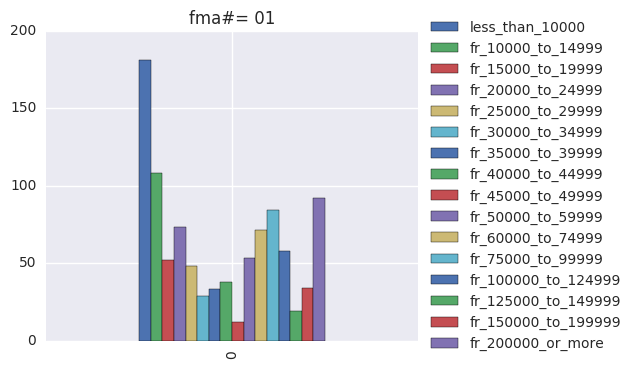

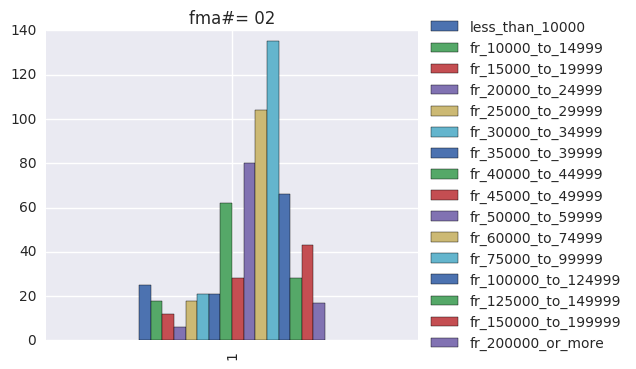

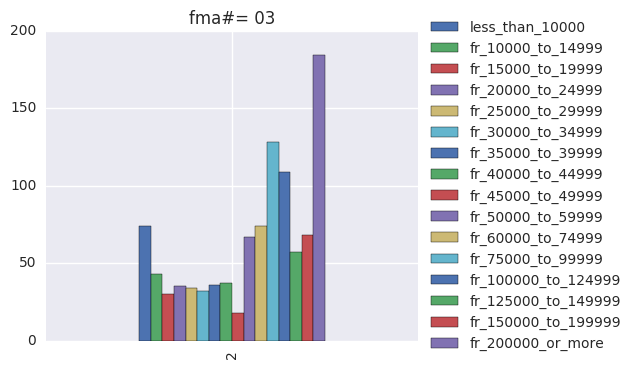

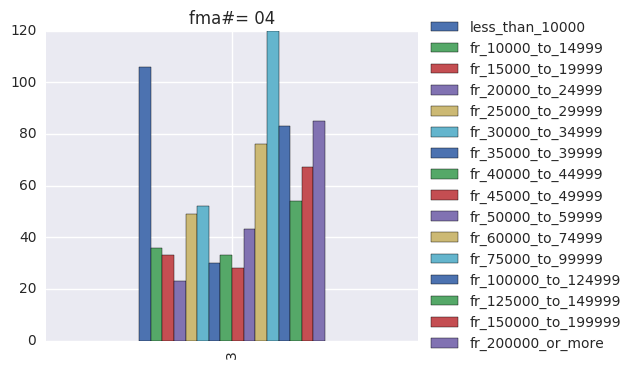

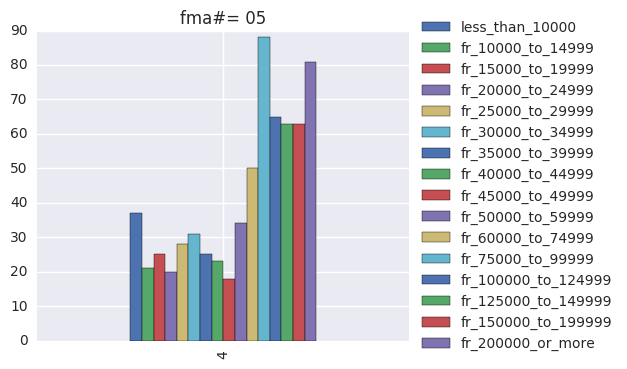

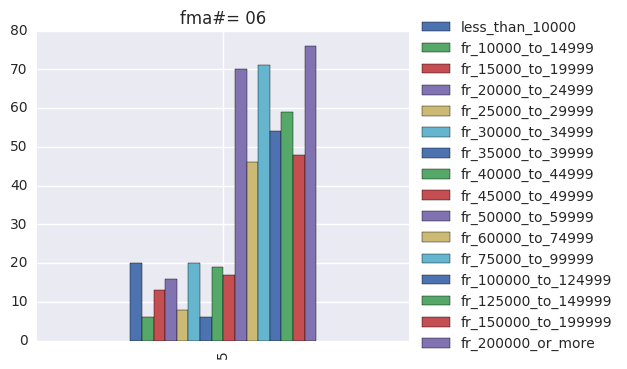

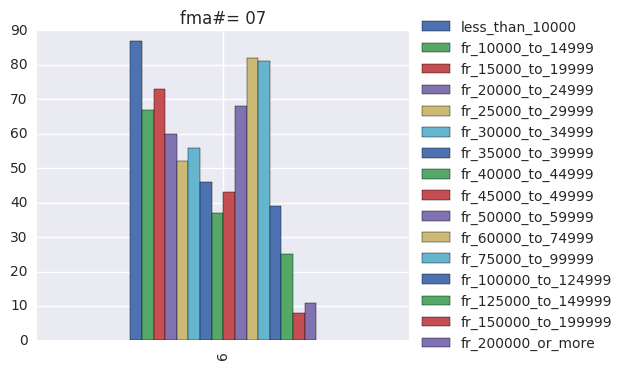

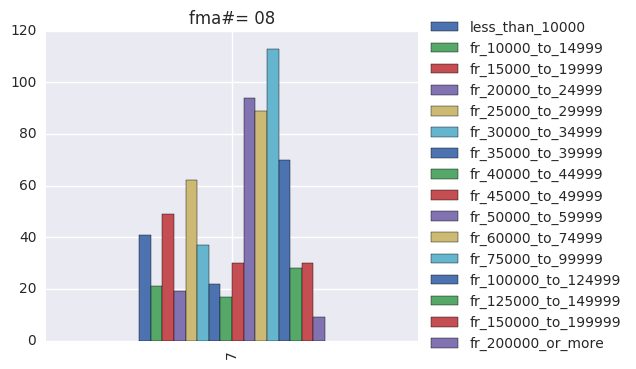

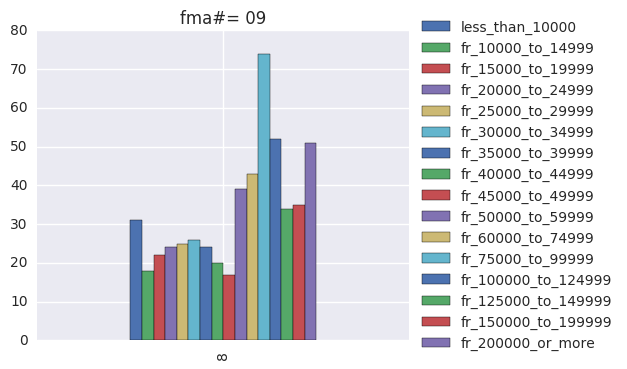

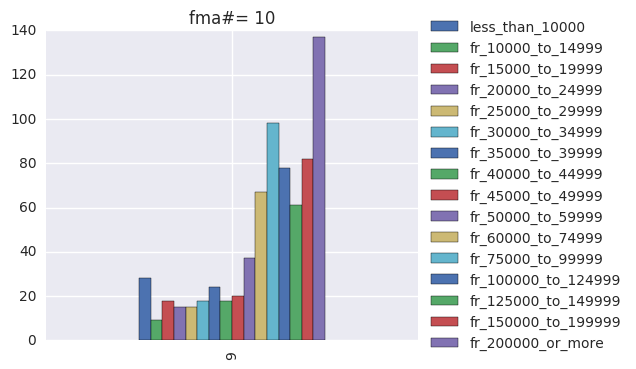

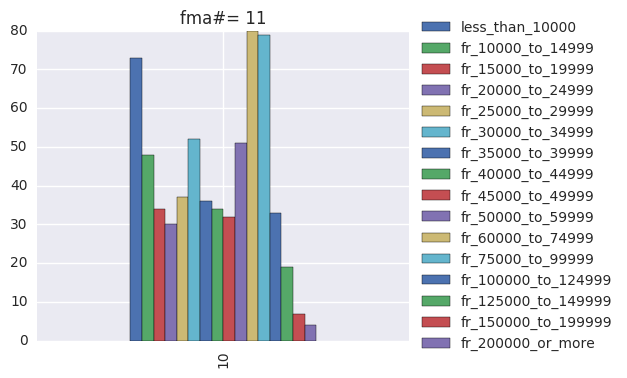

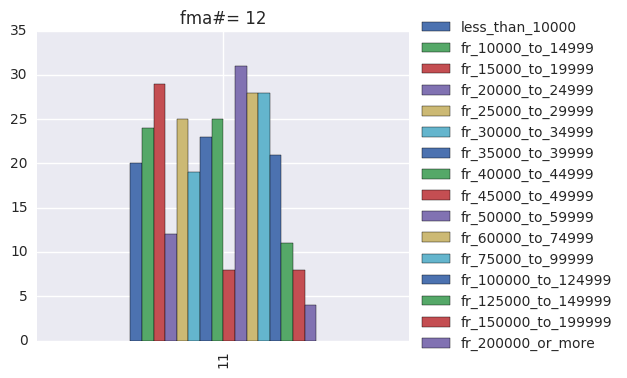

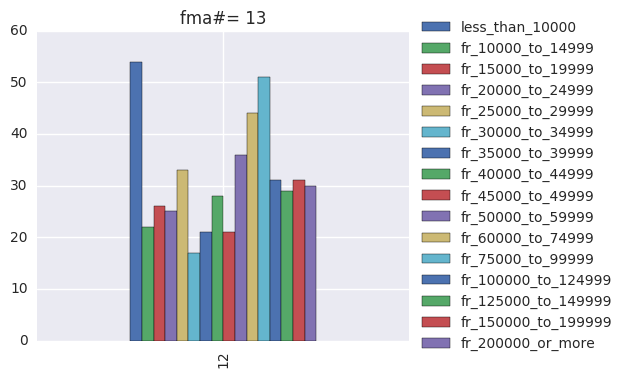

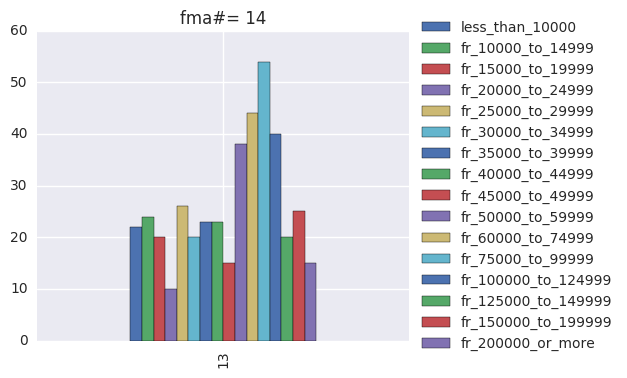

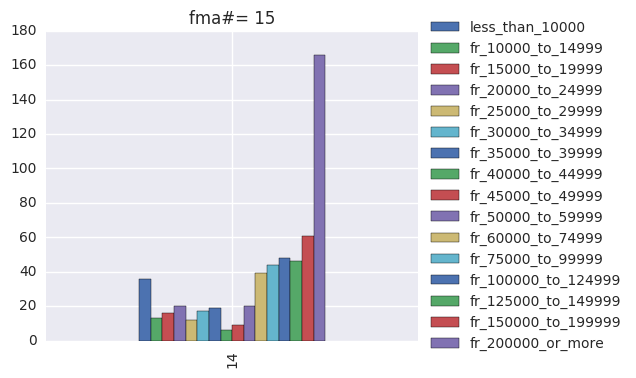

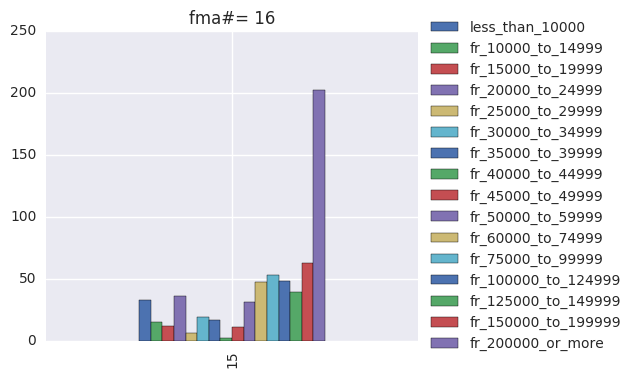

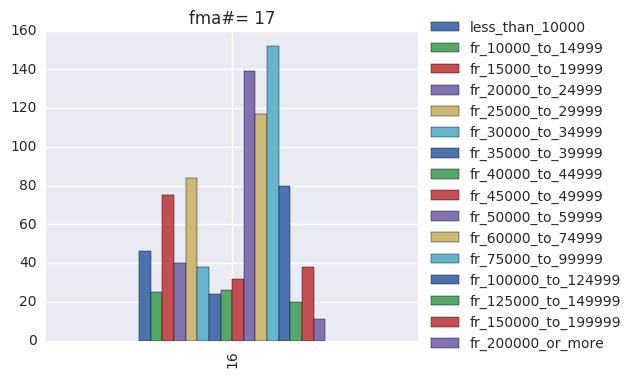

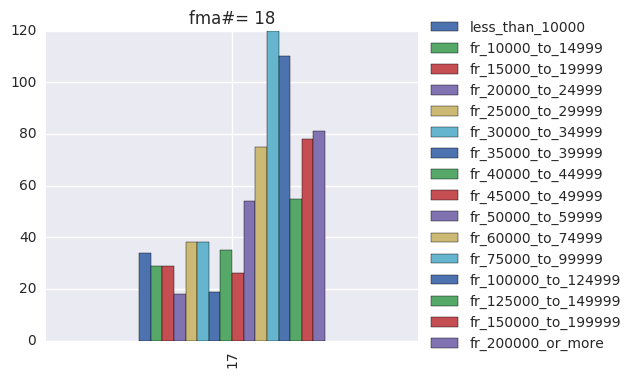

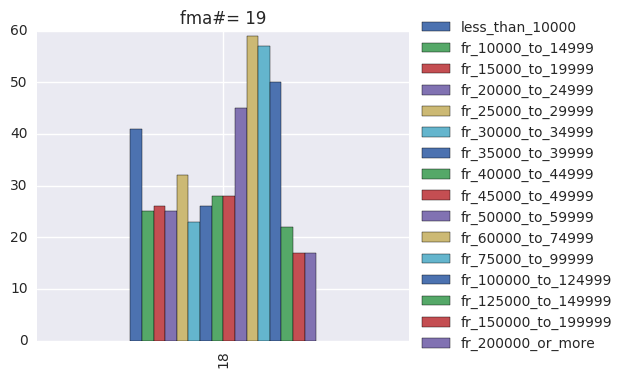

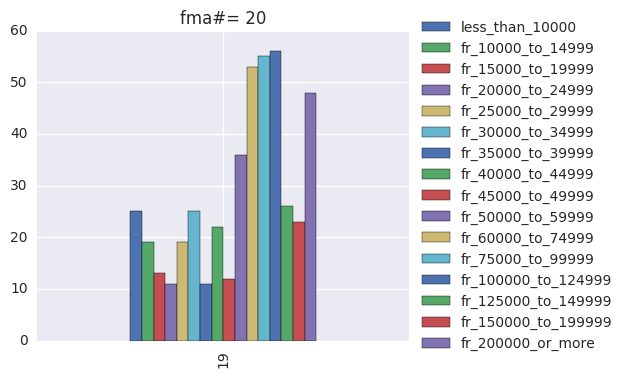

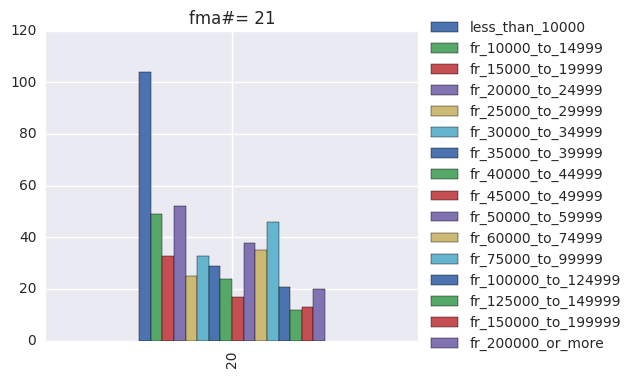

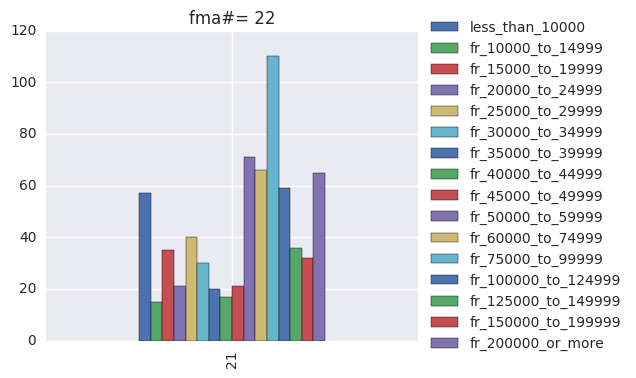

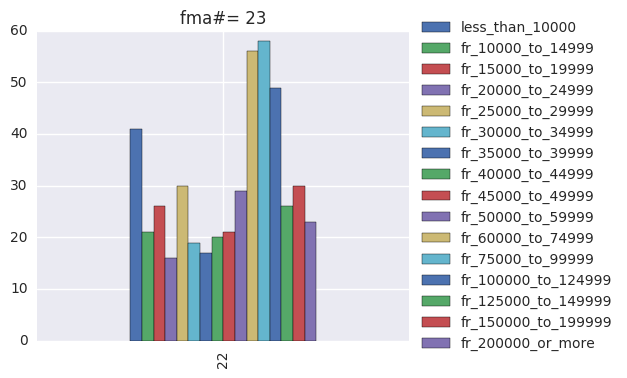

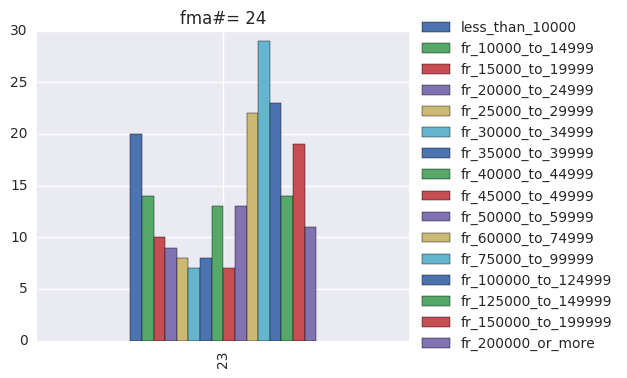

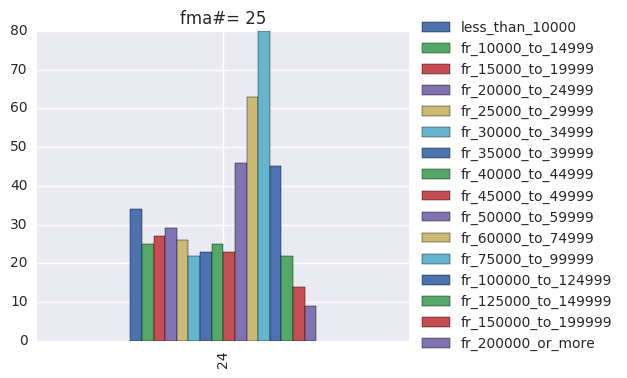

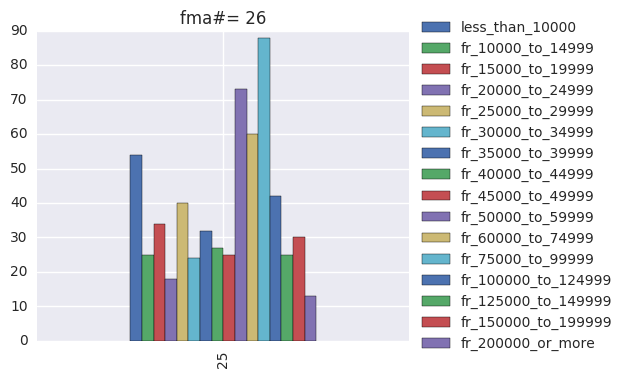

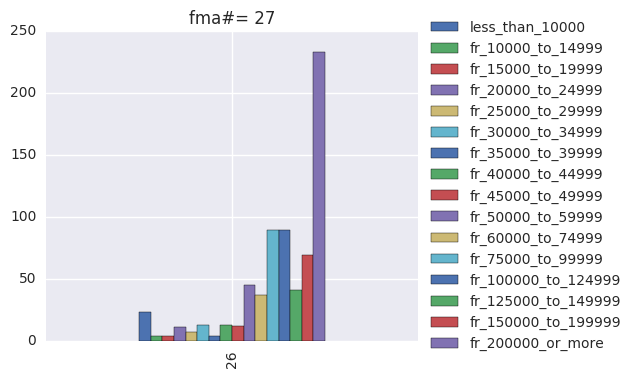

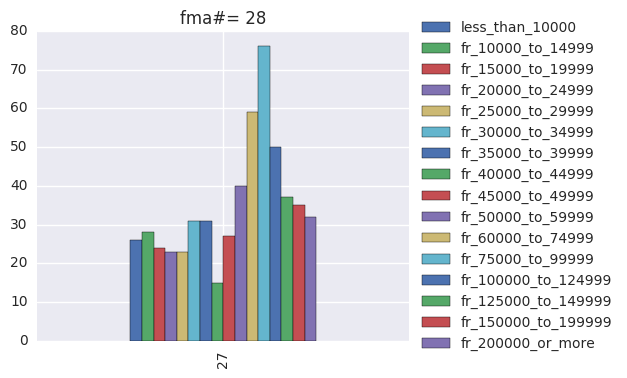

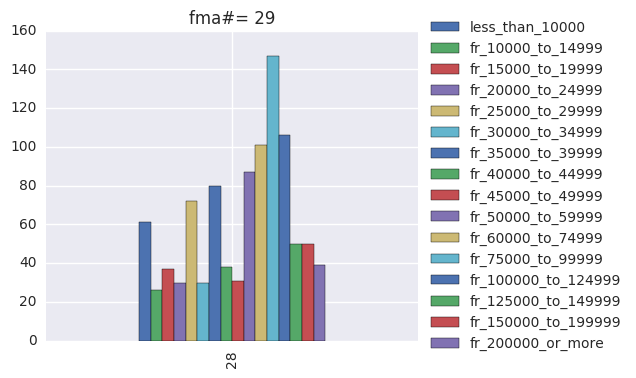

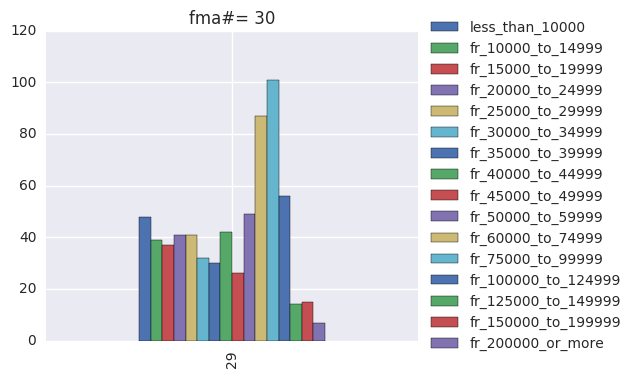

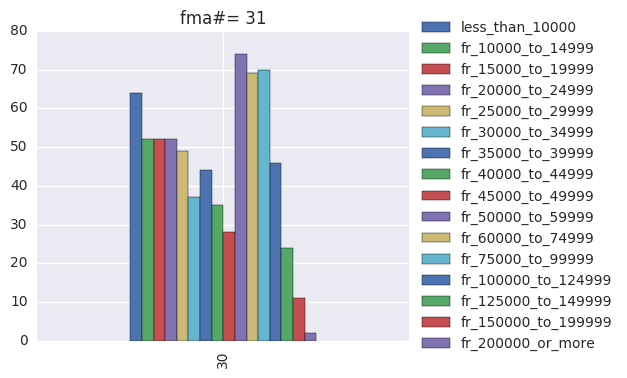

In [106]:
for i in df5['fma']:
    df5.loc[df5['fma'] == i,'less_than_10000':].plot(kind = 'bar',title = "fma#= "+str(i))
    # Shrink current axis by 20%
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
            